# Préambule

In [1]:
import sys
import os
from pathlib import Path

sys.path.insert(1, str(Path(os.getcwd()).parent))

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [3]:
from speed_constraint import calculate_latency_metrics
from math import ceil

def direct_method_streamlit(
  concurrent_users: int, 
  batch_size: int,
  gpu_troughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  model_layers: int,
  model_hidden_dim: int,
  bytes_per_param: float,
  input_length: int = 100,
  output_length: int = 1650,
):
    """
    Calcul du TTFT moyen à partir des formules de calculate_speed_constraint dans speed_constraint.py
    Le code commenté correspond aux formules de calculate_latency_metrics mais est moins fiable
    """
    effective_gpu_flops = gpu_troughput * 0.55

    effective_batchs = ceil(concurrent_users / batch_size)
    wait_factor = ((effective_batchs - 1) * effective_batchs / 2) / concurrent_users

    # flops_per_token = model_params * 2
    # gpu_tps = effective_gpu_flops / flops_per_token

    # latency_metrics = calculate_latency_metrics(
    #     gpu_tps, input_length, output_length, batch_size
    # )
    
    # return latency_metrics["ttft_ms"] / 1000 + latency_metrics["total_time_s"] * wait_factor

    generated_tokens = output_length / 3.7

    flops_prefill = 2 * batch_size * model_layers * input_length * model_hidden_dim * (2*model_hidden_dim + input_length)
    mm_prefill = bytes_per_param * (model_params + 2 * model_layers * batch_size * input_length * model_hidden_dim + batch_size * input_length * model_hidden_dim)
    time_prefill = max(flops_prefill / effective_gpu_flops, mm_prefill / gpu_bandwidth)

    flops_decode_one_token = batch_size * model_params * 2
    mm_params = model_params
    mm_kv_read = 2 * batch_size * input_length * model_hidden_dim
    mm_kv_write = 2 * batch_size * model_hidden_dim
    mm_decode_one_token = bytes_per_param * (mm_params + mm_kv_read + mm_kv_write)
    time_decode_one_token = max(flops_decode_one_token / effective_gpu_flops, mm_decode_one_token / gpu_bandwidth)

    total_time = time_prefill + (generated_tokens - 1) * time_decode_one_token

    return time_prefill + wait_factor * total_time




In [4]:
def direct_method_bis(
  concurrent_users: int, 
  batch_size: int,
  gpu_troughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  model_layers: int,
  model_hidden_dim: int,
  bytes_per_param: float,
  input_length: int = 100,
  output_length: int = 1650,
  ):
  """
  Calcul du TTFT moyen directement à partir des temps de traitement estimés des requêtes
  """
  from math import ceil
  
  # GPU compute throughput in FLOP/s
  # Convert from TFLOPS to FLOPS and apply efficiency factor
  GPU_EFFICIENCY_FACTOR = 0.55  # Default efficiency factor (~55% for fp16)
  
  # Calculate number of micro-batches
  effective_batchs = ceil(concurrent_users / batch_size)
  effective_troughput = gpu_troughput * GPU_EFFICIENCY_FACTOR

  # Size of the final (possibly partial) micro-batch
  prefill_compute = model_params*batch_size*input_length*bytes_per_param
  decode_compute = model_params*output_length*bytes_per_param
  prefill_memory = model_params*batch_size*bytes_per_param
  decode_memory = model_params*output_length*bytes_per_param

  # calculs
  prefill_time = prefill_compute/effective_troughput + prefill_memory/gpu_bandwidth
  decode_time = decode_compute/effective_troughput + decode_memory/gpu_bandwidth
  total_time = (prefill_time + decode_time)

  wait_factor = ((effective_batchs - 1) * effective_batchs / 2) / concurrent_users
  T_avg = prefill_time + total_time * wait_factor
  
  return T_avg


In [5]:
from calibration.queue_analysis import mm1_transient_mean, mm1_transient_percentile
from math import sqrt

def queue_theory_method(
  concurrent_users: int, 
  batch_size: int,
  gpu_troughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  model_layers: int = 2,
  model_hidden_dim: int = 2,
  n_gpus: int = 1,
  input_length: int = 100,
  output_length: int = 1650,
  ):
    """
    Calcul du TTFT moyen à partir d'un modèle de file d'attente M/M/c dont on
    estime les probabilités transcientes avec les méthodes de queue_analysis.py
    """
    
    theta = 0.5 # hyperparamètre qui dépend du comportement des utilisteurs
    h100_bandwidth = 3.2e12 # pour recalibration sur d'autres GPUs

    effective_troughput = gpu_troughput * 0.55

    # valeurs intermédiaires
    prefill_compute = model_params*batch_size*input_length*bytes_per_param
    decode_compute = model_params*output_length*bytes_per_param
    prefill_memory = model_params*batch_size*bytes_per_param
    decode_memory = model_params*output_length*bytes_per_param

    # calculs
    prefill_time = prefill_compute/effective_troughput + prefill_memory/gpu_bandwidth
    decode_time = decode_compute/effective_troughput + decode_memory/gpu_bandwidth
    total_time = (prefill_time + decode_time)

    # paramètres de la queue
    mu_heuristic = 2*(h100_bandwidth/gpu_bandwidth)
    λ = concurrent_users*theta/batch_size
    μ = (1/total_time) * 60 * mu_heuristic * n_gpus

    # print(f"λ = {λ}, μ = {μ}, t = {total_time}")

    # calculs
    t = 1
    mean_queue_length = mm1_transient_mean(λ, μ, t)*mu_heuristic
    percentile_queue_length = mm1_transient_percentile(λ, μ, t, 0.95)

    return mean_queue_length, percentile_queue_length


In [6]:
def get_predictions(
  x: list,
  batch_size: int,
  gpu_troughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  output_lengths: list,
  model_layers: int,
  model_hidden_dim: int,
  n_gpus: int = 1,
  input_length: int = 100,
):
  direct_pred = []
  direct_pred_bis = []
  queue_pred = []
  for concurrent_users, output_length in zip(x, output_lengths):
    direct_pred.append(direct_method_streamlit(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_troughput=gpu_troughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      input_length=input_length,
      output_length=output_length
    ))
    direct_pred_bis.append(direct_method_bis(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_troughput=gpu_troughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      input_length=input_length,
      output_length=output_length
    ))
    queue_pred.append(queue_theory_method(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_troughput=gpu_troughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      n_gpus=n_gpus,
      input_length=input_length,
      output_length=output_length
    )[0])
  return queue_pred, direct_pred, direct_pred_bis

# Comparaisons sur TTFT

On essaiera plus tard de faire des comparaisons sur le troughput en tokens/sec

## Mistral small

### 1 H100

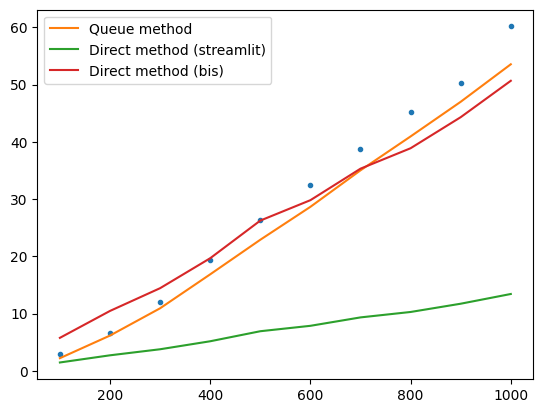

In [7]:
df = pd.read_csv("load_test_mistral.csv", sep=";")

y = df.iloc[:, 3]
output_lengths = df.iloc[:, 7]

x = [i*100 for i in range(1, 11)]
y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  model_layers=40,
  model_hidden_dim=5120,
  bytes_per_param=2,
  output_lengths=output_lengths,
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()
# plt.plot(x_predict, [b/100 + m*x/100 for x in x_predict])

C'est pas mal !

In [8]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  12.078616215148894
MSE direct method:  701.8153062321333
MSE direct(bis) method:  21.32385677842932


### 1 A100

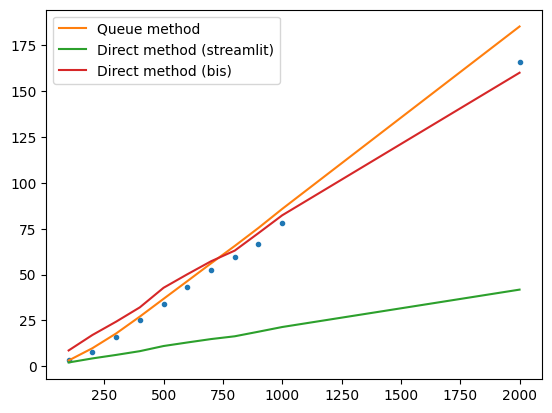

In [9]:
df = pd.read_csv("load_test_mistral_A100.csv", sep=";")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [i*100 for i in range(1, 11)] + [2000]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=3.12e14,
  gpu_bandwidth=2e12,
  model_params=24e9,
  model_layers=40,
  model_hidden_dim=5120,
  bytes_per_param=2,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

In [10]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  52.41317783235625
MSE direct method:  2376.532124965335
MSE direct(bis) method:  43.05446757645015


### 2 H100

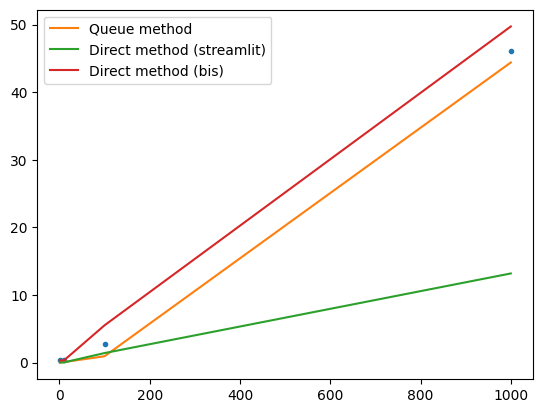

In [11]:
df = pd.read_csv("load_test_mistral_2H100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=2,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()


In [12]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  1.6501126500613608
MSE direct method:  272.12080008327814
MSE direct(bis) method:  5.115513225287181


## LLama 3.1 8b

### 1 H100

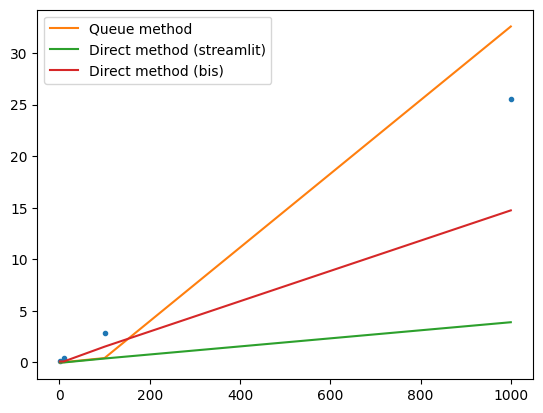

In [13]:
df = pd.read_csv("load_test_meta_H100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

In [14]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  13.83666995985246
MSE direct method:  118.83491914224484
MSE direct(bis) method:  29.69726993903369


### A100

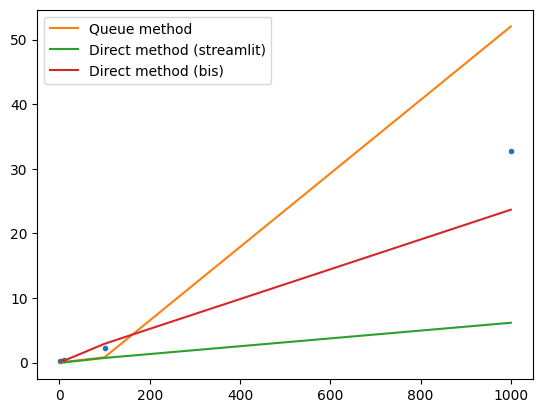

In [15]:
df = pd.read_csv("load_test_meta_A100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=3.12e14,
  gpu_bandwidth=2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

In [16]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  93.01012308771183
MSE direct method:  178.042355404777
MSE direct(bis) method:  20.958313390972467


## Gemma 27b

### 1 H100

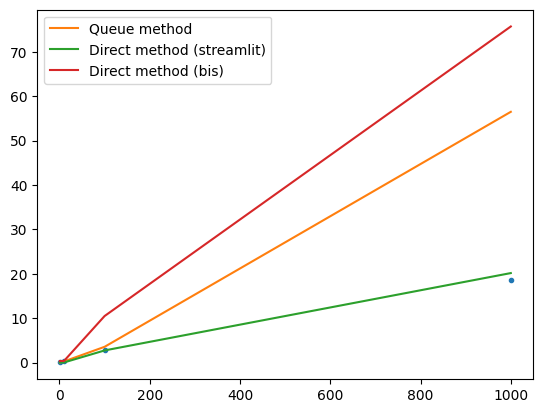

In [17]:
df = pd.read_csv("load_test_google_H100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]
x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=27e9,
  bytes_per_param=2,
  model_layers=60,
  model_hidden_dim=5376,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

A noter qu'on a 82,42% de requêtes qui échouent à 1000 requêtes concurrentes. Le fait que les formules du streamlit soient performantes à 1000 requêtes relève probablement du hasard.

## mistral anciennes données

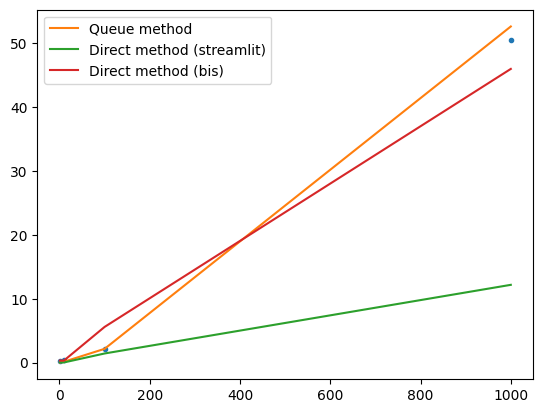

In [18]:
df = pd.read_csv("load_test_mistral_H100_old.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()